## Training Gesture Classification data set on Neural Network

In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [14]:
# read input data
input_dict = pd.read_pickle("./gestures_4d_full_compress_aligned.pkl")

In [6]:
print("shape of labels:", input_dict['labels'].shape)
print("shape of data:", input_dict['data'].shape)

shape of labels: (1, 6861)
shape of data: (6861, 120, 201)


In [17]:
# defineing labels id's of left, right and both side

lefthand_idx = [2,5,8,18,20,23,26,29,31,33,35,37,39,41,44,52]
righthand_idx = [1,4,7,9,17,19,22,25,28,30,32,34,36,38,40,43]
bothhand_idx = [0,3,6,10,11,12,13,14,15,16,21,24,27,42,45,46,47,48,49,50,51]

labels = np.array(input_dict['labels'])
data = input_dict['data']

# reshape labels
labels = labels.reshape(-1)

In [19]:
# creating mask for left right and both hands
# to filter the idx for each hands respectively 

# # initialize mask with zeros
mask = np.zeros_like(labels, dtype=bool)        
for id in lefthand_idx:
    maskid = labels == id
    mask = mask + maskid

lefthand_data = data[mask]
lefthand_labels = labels[mask]

# reset mask
mask = np.zeros_like(labels, dtype=bool)   
for id in righthand_idx:
    maskid = labels == id
    mask = mask + maskid

righthand_data = data[mask]
righthand_labels = labels[mask]

# reset mask again
mask = np.zeros_like(labels, dtype=bool)        
for id in bothhand_idx:
    maskid = labels == id
    mask = mask + maskid

bothhand_data  = data[mask]
bothhand_labels = labels[mask]

In [20]:
print("lefthand_data shape:", lefthand_data.shape)
print("righthand_data shape:", righthand_data.shape)
print("bothhand_data shape:", bothhand_data.shape)

print("sum_data shape:", lefthand_data.shape[0] + righthand_data.shape[0] + bothhand_data.shape[0])

print("lefthand_labels shape:", lefthand_labels.shape)
print("righthand_labels shape:", righthand_labels.shape)
print("bothhand_labels shape:", bothhand_labels.shape)

lefthand_data shape: (2034, 120, 201)
righthand_data shape: (1995, 120, 201)
bothhand_data shape: (2832, 120, 201)
sum_data shape: 6861
lefthand_labels shape: (2034,)
righthand_labels shape: (1995,)
bothhand_labels shape: (2832,)


In [21]:
# Defining labels into three-target-classes
# lefthand_labels = -1
# righthand_labels = 1
# bothhand_labels = 0

lefthand_target = np.ones_like(lefthand_labels) * -1
righthand_target = np.ones_like(righthand_labels)
bothhand_target = np.zeros_like(bothhand_labels)

print(lefthand_target.shape)
print(righthand_target.shape)
print(bothhand_target.shape)

(2034,)
(1995,)
(2832,)


In [22]:
all_labels = np.concatenate((lefthand_target, righthand_target, bothhand_target), axis=0)

all_data = np.concatenate((lefthand_data, righthand_data, bothhand_data), axis=0)

print(all_labels.shape)
print(all_data.shape)

(6861,)
(6861, 120, 201)


### implementation of neural network algorithms in pytorch

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Step 2: Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Step 3: Designing the neural network architecture
class GestureClassifier(nn.Module):
    def __init__(self, num_classes):
        super(GestureClassifier, self).__init__()
        self.rnn = nn.LSTM(input_size=201, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, num_classes)  # num_classes is the number of gesture classes

    def forward(self, x):
        _, (hidden, _) = self.rnn(x)
        hidden = hidden[-1]  # Get the hidden state of the last LSTM layer
        output = self.fc(hidden)
        return output

# Step 4: Training the neural network
num_classes = 53  # Replace with the actual number of gesture classes
num_epochs = 1000
batch_size = 32
learning_rate = 0.001

model = GestureClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

# Step 5: Evaluating the model
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        _, predicted = torch.max(output.data, 1)
        total_samples += batch_y.size(0)
        total_correct += (predicted == batch_y).sum().item()

accuracy = total_correct / total_samples
print(f"Accuracy: {accuracy}")


Accuracy: 0.9730517115804806


### confusion matrix 

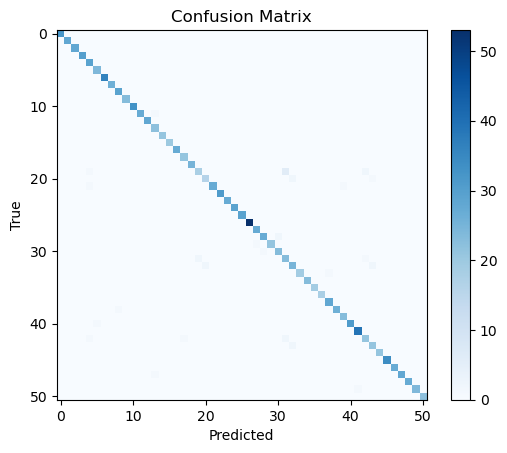

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        _, predicted = torch.max(output.data, 1)
        all_predictions.extend(predicted.tolist())
        all_labels.extend(batch_y.tolist())

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.imshow(conf_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


### Precision, Recall, and F1-score:

In [49]:
from sklearn.metrics import classification_report

classification_rep = classification_report(all_labels, all_predictions)
print(classification_rep)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        30
           4       0.91      1.00      0.95        29
           5       0.96      1.00      0.98        24
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        26
           8       0.97      1.00      0.98        29
           9       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        33
          11       1.00      0.96      0.98        28
          12       1.00      1.00      1.00        28
          13       0.92      1.00      0.96        22
          14       1.00      1.00      1.00        21
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        27
          17       0.95    